In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import cebra
from PIL import Image
import cv2
import os
import torch
import torch.nn.functional as F
from torch import nn
import itertools
from torch.utils.tensorboard import SummaryWriter
import random
import gc
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import MeanShift, estimate_bandwidth, OPTICS


In [2]:
from torch import nn
import cebra.models
import cebra.data
from cebra.models.model import _OffsetModel, ConvolutionalModelMixin

class ChangeOrderLayer(nn.Module):
    def forward(self, x):
        return x.movedim(-2,1)  # Permute dimensions 1 and 2

@cebra.models.register("convolutional-model-offset11")
class ConvulotionalModel1(_OffsetModel, ConvolutionalModelMixin):

    def __init__(self, num_neurons, num_units, num_output, normalize=True):
        super().__init__(
            ## create a model which goes from a 128 x 128 image to a 1d vector
            ## of length num_output
            ChangeOrderLayer(),
            nn.Conv2d(5, 16, kernel_size=3, stride=1, padding=1),
            nn.GELU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.GELU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Flatten(),
            nn.Linear(1024, num_output),

            num_input=num_neurons,
            num_output=num_output,
            normalize=normalize,
        )

    # ... and you can also redefine the forward method,
    # as you would for a typical pytorch model

    def get_offset(self):
        return cebra.data.Offset(2, 3)


In [3]:
cebra_model_path = 'models/cebra_model_complete.pt'


In [4]:
data_directory = '/mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/'
neural_data_paths = [ data_directory + 'brain/' + \
                     file for file in os.listdir(data_directory + 'brain/')]

behavior_data_paths = [  data_directory + 'camera1/' + \
                     file for file in os.listdir(data_directory + 'brain/')]

dino_paths = [ data_directory + 'dino/' + \
                        file for file in os.listdir(data_directory + 'brain/')]

output_folder_paths = [ data_directory + 'output2/' + \
                        file for file in os.listdir(data_directory + 'brain/')]

In [5]:

def process_brain(brain_seq):
  brain_seq = np.array(brain_seq)
  flat_seq = np.array([(brain_frame.flatten()) for brain_frame in brain_seq])
  return flat_seq.astype(float)

## Loads data from a folder of TIF files
# filepath: path to folder
# processor: function to process each image
# max: max images to load as a proportion of array size
# min: min images to load as a proportion of array size
# returns: list of processed images, list of filenames
def import_data(filepath, processor, min = 0, max = 1):
    output_data = []
    output_name = []
    path_list = os.listdir(filepath)
    path_list.sort()
    random.Random(4).shuffle(path_list)
    min_index = int(min * len(path_list))
    max_index = int(max * len(path_list))
    for file in itertools.islice(path_list, min_index, max_index):
     filename = os.fsdecode(file)
     if filename.endswith(".tif"):
         out = cv2.imreadmulti(filepath + '/' + filename)[1]
         output_data.append(processor(out))
         output_name.append(filename.split('.')[0])
     elif filename.endswith(".npy"):
         output_data.append(processor(np.load(filepath + '/' + filename)))
         output_name.append(filename.split('.')[0])
     else:
         continue
    return output_data, output_name

def flatten_data(data):
    return np.concatenate(data, axis=0)

def pad_data(data, pre, post):
    pre_padding = np.repeat(np.expand_dims(data[0], axis = 0), pre, axis=0)
    post_padding = np.repeat(np.expand_dims(data[-1], axis = 0), post, axis=0)
    return np.concatenate((pre_padding, data, post_padding), axis=0)

def generate_CEBRA_embeddings(model, data, session_id, offset = (2,3)):
    data_torch = torch.empty(0,5,128,128)
    padded = pad_data(data, offset[0], offset[1])
    for i, frame in enumerate(data):
        frame = torch.from_numpy(np.array(padded[i: i + offset[0] + offset[1]])).float().unsqueeze(0)
        data_torch = torch.cat((data_torch, frame), dim = 0)
    data_torch = data_torch.swapdims(-2, 1)
    embedding = model[session_id](data_torch).detach().cpu().numpy().squeeze()
    return embedding

def load_model(model_path):
    #find available device
    saved_solver = torch.load(model_path)
    model = saved_solver.model
    return model

def reshape_frames(frames, shape_ref):
    shape_list = [np.shape(x)[0] for x in shape_ref]
    gen_video_list = []
    index = 0
    for shape in shape_list:
        gen_video_list.append((frames[index : index + shape]))
        index += shape
    return gen_video_list

#choose a random window of set size from the data deterministically based on seed
def choose_random_window( window_size, seed, data):
    random.seed(seed)
    start = random.randint(0, len(data) - window_size)
    return data[start:start+window_size]


In [6]:
def normalize_array(in_array):
    return np.array([x / np.linalg.norm(x) for x in in_array])

def match_frame_to_embeddings(predicted_embedding, embedding_train, image_train):
  cos_dist = np.matmul(embedding_train, predicted_embedding.T)
  index_list = np.argmax(cos_dist, axis=0)
  return image_train[index_list]

def predict_embeddings(neural_path, behavior_path,dino_path, validation_cutoff, valid_size, model, session):
    # Load data
    print('Loading data')
    brain_data, name_data = import_data(neural_path, lambda x: x, max=validation_cutoff)
    behavior_data, _ = import_data(behavior_path, lambda x: x, max=validation_cutoff)
    dino_data, _ = import_data(dino_path, lambda x: x, max=validation_cutoff)
    # Generate embeddings
    print('Generating embeddings')
    embeddings = [generate_CEBRA_embeddings(model, brain_data_vid, session) for brain_data_vid in brain_data]

    print('Loading test data')
    # Load the test set of data
    brain_data_test, name_data_test = import_data(neural_path, lambda x: x, min = validation_cutoff, max=validation_cutoff + valid_size)
    behavior_data_test, _ = import_data(behavior_path, lambda x: x, min = validation_cutoff, max=validation_cutoff + valid_size)
    dino_data_test, _ = import_data(dino_path, lambda x: x, min = validation_cutoff, max= validation_cutoff + valid_size)
    # Generate embeddings
    print('Generating test embeddings')
    embeddings_test = [generate_CEBRA_embeddings(model, vid_test, session) for vid_test in brain_data_test]

    # Flatten Data
    embeddings_flat = flatten_data(embeddings).squeeze()
    behavior_flat = flatten_data(behavior_data).squeeze()
    dino_flat = flatten_data(dino_data).squeeze()
    embedding_test_flat = flatten_data(embeddings_test).squeeze()
    dino_test_flat = flatten_data(dino_data_test).squeeze()

    print('Running KNN')
    # Create KNN decoder
    decoder = cebra.KNNDecoder(n_neighbors=20, metric="cosine")
    decoder.fit(embeddings_flat, dino_flat)

    # predict
    predicted_dino = decoder.predict(embedding_test_flat)

    # normalize predicted embeddings
    predicted_dino = normalize_array(predicted_dino)

    print('generating videos')
    # Match predicted embeddings to images
    predicted_images = match_frame_to_embeddings(predicted_dino, dino_flat, behavior_flat)
    reshaped_predicted_images = reshape_frames(predicted_images, brain_data_test)

    print('Running Clustering')
    #run Agglomerative clustering to predict class labels
    clustering = AgglomerativeClustering(n_clusters=3, metric='cosine', linkage='average').fit(embedding_test_flat)
    predicted_labels_flat = clustering.labels_

    #reshape predicted labels
    predicted_labels = reshape_frames(predicted_labels_flat, brain_data_test)

    return reshaped_predicted_images, name_data_test, predicted_labels, behavior_data_test


In [7]:
def display_frames_as_video(frames, ground_truth, frame_rate, name, labels, label_dict, output_folder_path):
    fontScale = 0.5
    org = (50, 50)
    font = cv2.FONT_HERSHEY_SIMPLEX
    thickness = 1
    # Get the dimensions of the frames
    frame_height, frame_width = frames[0].shape
    # Classify video based on median label of all frames
    label = np.round(np.median(labels))
    label_class = label_dict[label]
    # Create a VideoWriter object to write the frames into a video file
    video_writer = cv2.VideoWriter(output_folder_path + '/'+ str(label) + '_' + name +'.mp4',
                                   cv2.VideoWriter_fourcc(*'mp4v'),
                                   frame_rate,
                                   (frame_width, 2 * frame_height))

    # Display frames
    for iter, frame in enumerate(zip(frames, ground_truth, labels)):
        # Write the current frame to the video file
        color_frame = cv2.cvtColor(((frame[0]/2 + frames[iter - 1]/2)).astype(np.uint8), cv2.COLOR_GRAY2RGB)
        color_truth = cv2.cvtColor(frame[1].astype(np.uint8), cv2.COLOR_GRAY2RGB)
        combined = np.concatenate((color_frame, color_truth))

        # write corresponding label to video corner
        combined  = cv2.putText(combined, str(frame[2]) , org, font, 
                   fontScale, (0,0,255), thickness, cv2.LINE_AA)
        video_writer.write(combined)

    # Release the VideoWriter and close the window
    video_writer.release()
    cv2.destroyAllWindows()

In [8]:
label_classes = {0 : '0', 1 : '1', 2 : '2'}

In [9]:
solver = torch.load('models/cebra_model_complete.pt')
model = solver.model.eval()
for i, _ in enumerate(zip(neural_data_paths, behavior_data_paths, dino_paths)):
    pred_images, names, labels, predict_behavior = predict_embeddings(neural_data_paths[i], behavior_data_paths[i], dino_paths[i], 0.8, 0.2, model, i)
    for data in zip(labels, pred_images, names, predict_behavior):
        windowed_labels = choose_random_window(30, data[2], data[0])
        windowed_frames = choose_random_window(30, data[2], data[1])
        windowed_truth = choose_random_window(30, data[2], data[3])
        display_frames_as_video(windowed_frames, windowed_truth, 30, data[2], windowed_labels, label_classes, output_folder_paths[i])

Loading data
Generating embeddings
Loading test data
Generating test embeddings
Running KNN
generating videos
Running Clustering
Loading data
Generating embeddings


In [ ]:
from matplotlib.colors import ListedColormap
from sklearn.manifold import TSNE
import matplotlib as mpl
from sklearn.cluster import KMeans

solver = torch.load('models/cebra_model_complete.pt')
model = solver.model

print('Loading data')
brain_data, name_data = import_data(neural_data_paths[4], lambda x : x, max=0.05)
print ('Generating embeddings, num sessions: ', len(brain_data))
embeddings = [generate_CEBRA_embeddings(model, session, 4) for session in brain_data]
embedding_flat = flatten_data(embeddings).squeeze()


print('Running TSNE')
tsne_embedding = TSNE(n_components=2, n_iter=2500, learning_rate='auto', metric='cosine',
                init='random', perplexity=30).fit_transform(embedding_flat)

print('Running Clustering') 
clustering = OPTICS(min_samples=10, metric='cosine').fit(embedding_flat)
predicted_labels_flat = clustering.labels_
predicted_labels_flat2 = KMeans(n_clusters=3).fit(embedding_flat).labels_
predicted_labels_flat3 = AgglomerativeClustering(n_clusters=3, metric='cosine', linkage='average').fit(embedding_flat).labels_

colors = mpl.colormaps['magma']
classes = ['still', 'running', 'sniffing']


Loading data
Generating embeddings, num sessions:  68
Running TSNE
Running Clustering


/home/murph_4090ws/miniconda3/envs/cebra-env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


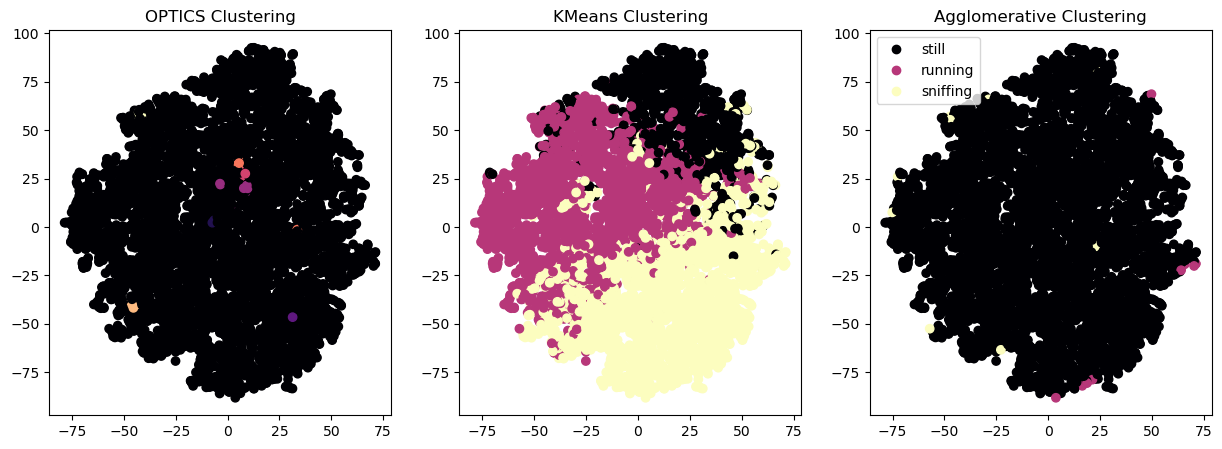

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
#plot tsne plot as a scatterplot with labels
scatter1 = ax1.scatter(tsne_embedding[:,0], tsne_embedding[:,1], c=predicted_labels_flat, cmap=colors)
ax1.set_title('OPTICS Clustering')
scatter2 = ax2.scatter(tsne_embedding[:,0], tsne_embedding[:,1], c=predicted_labels_flat2, cmap=colors)
ax2.set_title('KMeans Clustering')
scatter3 = ax3.scatter(tsne_embedding[:,0], tsne_embedding[:,1], c=predicted_labels_flat3, cmap=colors)
ax3.set_title('Agglomerative Clustering')

plt.legend(handles=scatter1.legend_elements()[0], labels=classes)
plt.legend(handles=scatter2.legend_elements()[0], labels=classes)
plt.legend(handles=scatter3.legend_elements()[0], labels=classes)

plt.show()

In [ ]:
print(np.unique(predicted_labels_flat))

[0]
